# Task 2 — Stock EDA (pandas-only)

This notebook loads a stock CSV from `stock_data/` (prefers AAPL), computes basic technical indicators using pandas (SMA(20), RSI(14), MACD(12,26,9)), and plots results. It avoids `pandas_ta`/`numba` to ensure compatibility with the environment.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

# Locate a stock CSV file (prefer AAPL)
candidates = [os.path.join('..','stock_data','AAPL.csv'), os.path.join('stock_data','AAPL.csv')]
csv_path = None
for p in candidates:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    # Search fallback in both possible folders
    for folder in [os.path.join('..','stock_data'), 'stock_data']:
        if os.path.isdir(folder):
            for fname in os.listdir(folder):
                if fname.endswith('.csv'):
                    csv_path = os.path.join(folder, fname)
                    break
        if csv_path:
            break
if csv_path is None:
    raise FileNotFoundError('No CSV files found in ../stock_data or stock_data')

print('Using file:', csv_path)


Using file: ..\stock_data\AAPL.csv


In [13]:
# Load the CSV and normalize columns
df = pd.read_csv(csv_path)
# Normalize Date column name and convert to datetime (coerce invalid values)
date_col = 'Date' if 'Date' in df.columns else ('date' if 'date' in df.columns else None)
if date_col is None:
    raise KeyError('No Date column found in the CSV')
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
if date_col != 'Date':
    df = df.rename(columns={date_col: 'Date'})
df = df.set_index('Date').sort_index()
# Ensure Close column exists (try common alternatives)
if 'Close' not in df.columns:
    for alt in ['close','Adj Close','Adj_Close','AdjClose']:
        if alt in df.columns:
            df = df.rename(columns={alt:'Close'})
            break


In [15]:
# Compute indicators using pandas (no pandas_ta)
# SMA 20
df['SMA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()

# RSI (14) - Wilder smoothing using EWM
close = df['Close']
delta = close.diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
roll_up = up.ewm(alpha=1/14, adjust=False).mean()
roll_down = down.ewm(alpha=1/14, adjust=False).mean()
rs = roll_up / roll_down
df['RSI_14'] = 100.0 - (100.0 / (1.0 + rs))

# MACD (12,26,9)
ema12 = close.ewm(span=12, adjust=False).mean()
ema26 = close.ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Daily returns
df['Daily_Return'] = df['Close'].pct_change()

# Show a quick preview
df[['Close','SMA_20','RSI_14','MACD','Daily_Return']].head()


,Close,SMA_20,RSI_14,MACD,Daily_Return
Date,,,,,
2009-01-02,2.721686,2.721686,NaN,0.000000,NaN
2009-01-05,2.836553,2.779120,100.000000,0.009163,0.042204
2009-01-06,2.789767,2.782669,96.962043,0.012506,-0.016494
2009-01-07,2.729484,2.769372,93.039987,0.010173,-0.021609
2009-01-08,2.780169,2.771532,93.285895,0.012273,0.018570


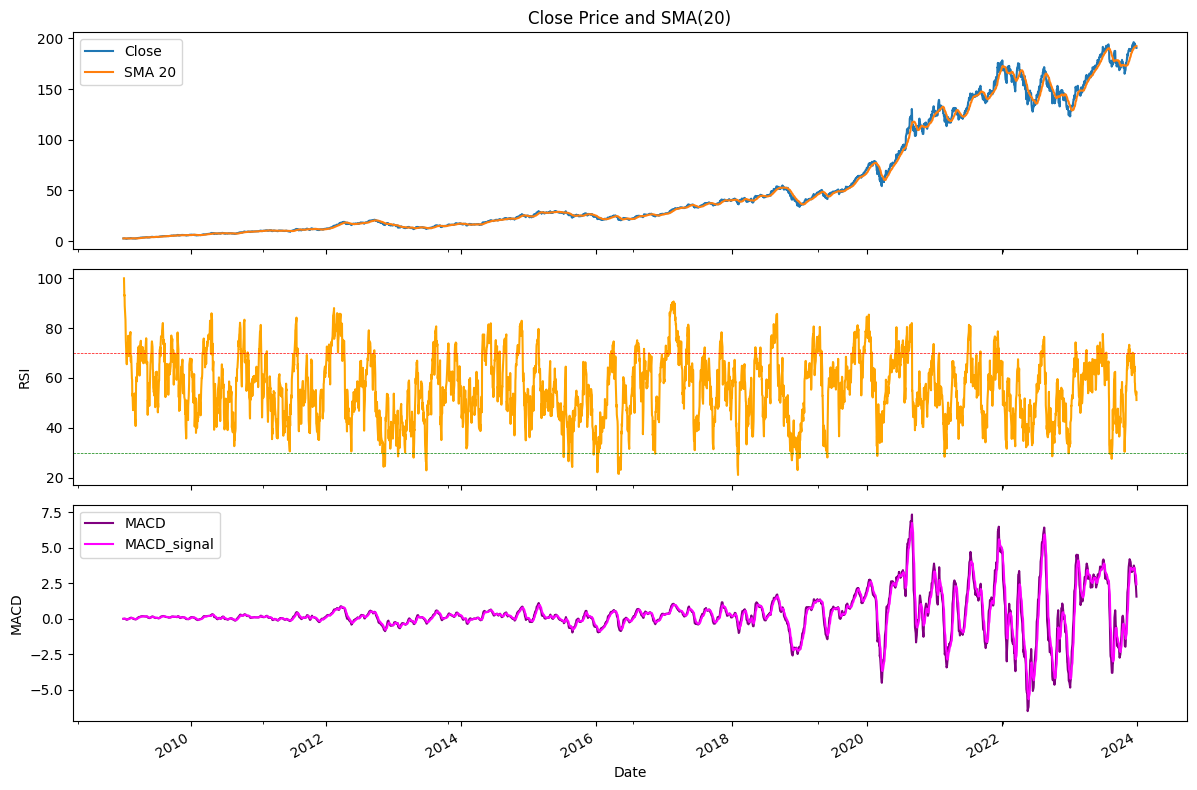

In [16]:
# Plots: Close+SMA, RSI, MACD
plt.rcParams['figure.figsize'] = (12, 8)
ax1 = plt.subplot(3,1,1)
df['Close'].plot(ax=ax1, label='Close')
df['SMA_20'].plot(ax=ax1, label='SMA 20')
ax1.set_title('Close Price and SMA(20)')
ax1.legend()
ax2 = plt.subplot(3,1,2, sharex=ax1)
df['RSI_14'].plot(ax=ax2, color='orange')
ax2.axhline(70, color='red', linestyle='--', linewidth=0.5)
ax2.axhline(30, color='green', linestyle='--', linewidth=0.5)
ax2.set_ylabel('RSI')
ax3 = plt.subplot(3,1,3, sharex=ax1)
df['MACD'].plot(ax=ax3, color='purple', label='MACD')
df['MACD_signal'].plot(ax=ax3, color='magenta', label='MACD_signal')
ax3.set_ylabel('MACD')
ax3.legend()
plt.tight_layout()
plt.show()


In [ ]:
df[['Close','SMA_20','RSI_14','MACD','Daily_Return']].tail()